In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

import config
import data_loader
import features
import model

Using TensorFlow backend.


We describe an alternative loss function, that includes both the optimum and the first found solution of the solver (which we have to beat to make an impact with boundary estimation).

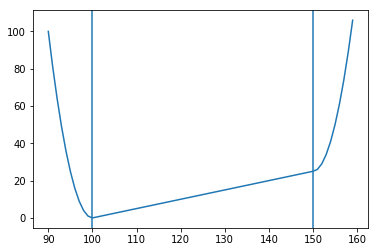

In [31]:
def double_bound_loss(pred, opt, firstsol, linear_scale=0.5):
    return np.where((opt <= pred) & (pred <= firstsol),
                    linear_scale * (pred - opt),
                    0) + np.where((pred < opt), (pred - opt)**2, 0) + np.where((firstsol < pred), linear_scale * (firstsol-opt) + (pred - firstsol)**2, 0)

opt = 100
firstsol = 150
loss_inp = np.array(range(90, 160))
loss_res = double_bound_loss(loss_inp, opt, firstsol)
plt.plot(loss_inp, loss_res)
ax = plt.gca()
ax.axvline(opt)
ax.axvline(firstsol)

In the next sections, we export the optima and first solutions for all instances, but we also identify the instances for which we lack a first solution (due to timeouts in our normal runs) and create a file to identify these solutions.

In [2]:
def first_solutions(mzn_name, solver=None, logfile='logs/solver_evaluation_o2_scaled_y.csv'):
    df = pd.read_csv(logfile)
    df.mzn = df.mzn.str.replace('_boundest.mzn', '.mzn')
    
    df = df[(df.bounds == 'No') & (df.mzn == mzn_name)][['mzn', 'dzn', 'solver', 'first_objective']]

    if solver:
        df = df[df.solver == solver]
    else:
        df = df.groupby(['mzn', 'dzn'], as_index=False).min()
    
    return pd.DataFrame(df[df.first_objective.notnull()][['mzn', 'dzn', 'first_objective']])


In [80]:
df = pd.read_csv('logs/solver_evaluation_o2_scaled_y.csv')
df = df[(df.bounds == 'No') & (df.mzn != 'tsp.mzn')][['mzn', 'dzn', 'solver', 'first_objective']]
df.sort_values(['mzn', 'dzn', 'solver', 'first_objective'], inplace=True)
missing_first = df[df.first_objective.isna() | (df.mzn == '2DLevelPacking.mzn')]
df = df[~df.first_objective.isna()]
df['first_objective'] = df['first_objective'].astype(int)
df.to_csv('first_solutions_found.csv', index=False)

In [81]:
missing_first.mzn.unique()

array(['2DLevelPacking.mzn', 'cutstock.mzn', 'mrcpsp.mzn'], dtype=object)

In [82]:
with open('find_missing', 'w') as f:
    for i, (_, r) in enumerate(missing_first.iterrows()):
        mzn = r.mzn.replace('.mzn', '_satisfy.mzn')
        log_name = "{}_{}_{}_firstsol.txt".format(r.solver, r.mzn, r.dzn)
        output = "{};{};{};\\1".format(r.solver, r.mzn, r.dzn)
        print("minizinc --solver {} $(find . -name {}) $(find . -name {}) | grep objective | sed 's/^objective = \(.*\);/{}/' > {}".format(r.solver, mzn, r.dzn, output, log_name), file=f)


In [35]:
def get_data(p):
    firstsol = first_solutions(p.mzn)
    X, y = features.cached_feature_matrix(p, include_opt=True, include_mzn2feat=True)
    y = pd.concat([y, firstsol.set_index('dzn')], axis=1, join='inner')
    return X, y   

In [41]:
from keras import backend as K
from keras import regularizers, callbacks
from keras.engine import Input, Model
from keras.layers import average, maximum, Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def get_model(input_dim):
    hidden_nodes = 32
    hidden_layers = 3
    outputs = 1
    initializer = 'glorot_normal'

    regularizer = regularizers.l2(0.001)

    inp = Input(shape=(input_dim,))

    x = Dense(hidden_nodes, activation='tanh',
              kernel_initializer=initializer,
              kernel_regularizer=regularizer,
              use_bias=False)(inp)

    for i in range(1, hidden_layers - (outputs == 2)):
        x = Dense(hidden_nodes, activation='tanh',
                  bias_initializer='ones',
                  kernel_initializer=initializer,
                  kernel_regularizer=regularizer)(x)

    output_activation = 'sigmoid' # 'sigmoid'  # 'linear'
    pred = Dense(1, activation=output_activation, bias_initializer='ones')(x)

    linear_scale = 1
    loss = K.tf.where(K.less(pred, opt),
                      linear_scale * (firstsol-opt)**2 + (opt - pred)**2, 
                      K.zeros(shape=(opt.shape[0], 1))) + \
           K.tf.where(K.tf.logical_and(K.less_equal(opt, pred), K.less_equal(pred, firstsol)),
                      linear_scale * (pred - opt),
                      K.zeros(shape=(opt.shape[0], 1))) + \
           K.tf.where(K.less(firstsol, pred), 
                      linear_scale * (firstsol-opt)**2 + (pred - firstsol)**2, 
                      K.zeros(shape=(opt.shape[0], 1)))

    #print(opt, firstsol)

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)
    early_stop = callbacks.EarlyStopping(patience=11)

    #loss = (K.tf.where(K.tf.logical_and(K.less_equal(opt, pred), K.less_equal(pred, firstsol)), 
    #                   0.5*(pred - opt), 
    #                   K.tf.maximum(0.5*(opt-firstsol), 0) + (pred - opt)**2)) #+ (pred < opt) * (pred - opt)**2 + (firstsol < pred) * ((firstsol-opt) + (pred-firstsol)**2)
    loss = K.mean(loss)
    optimizer = Adam(lr=1e-2)
    model = Model([inp], pred)
    #model.add_loss(loss)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mape', 'mse'])  # model.add_loss(loss)
    return model

def prepare_data(X, y):
    X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(X, y, test_size=0.2)

    #x_scaler = MinMaxScaler((-1, 1))
    x_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train_unscaled)
    X_val = x_scaler.transform(X_val_unscaled)

    y_scaler = MinMaxScaler().fit(np.array([y_train['dom_lower'].min(), y_train['dom_upper'].max()]).astype(np.float32).reshape(-1, 1))

    opt = y_scaler.transform(y_train['optimum'].values.astype(np.float32).reshape(-1, 1))
    firstsol = y_scaler.transform(y_train['first_objective'].values.astype(np.float32).reshape(-1, 1))

    #opt = y_train['optimum'].values.astype(np.float32).reshape(-1, 1)
    #firstsol = y_train['first_objective'].values.astype(np.float32).reshape(-1, 1)
    
    return X_train, X_val, y_train, y_val, opt, firstsol


In [ ]:
model = get_model()

hist = model.fit(X_train, opt+(firstsol-opt)/4, batch_size=32, epochs=2000, verbose=0)  #y_train.shape[0]
print(hist.history['loss'][-1])
y_pred = model.predict(X_val)
y_val['pred_unsc'] = y_pred
y_val['pred'] = y_scaler.inverse_transform(y_pred)
y_val

In [38]:
def fixed_bounds(y_train, y_val):
    rows = []
    for i in range(1, 44):
        i = i/4
        fixed_bound = y_train['optimum'].mean() + (y_train['first_objective'].mean() - y_train['optimum'].mean()) / i
        good_estimates = ((y_val['optimum'] <= fixed_bound) & (fixed_bound <= y_val['first_objective'])).mean().round(4)*100
        opt_gap = ((fixed_bound - y_val['optimum'])/(y_val['first_objective'] - y_val['optimum'])).mean().round(4)*100
        print(i, '\t', good_estimates, '\t', opt_gap)
        rows.append((i, good_estimates, opt_gap))
        
    df = pd.DataFrame(rows, columns=['i', 'good_estimates', 'opt_gap'])
    df['method'] = 'mean'
    return df

In [39]:
def model_bounds(X_train, X_val, y_train, y_val):
    rows = []
    for i in range(1, 44):
        i = i/4
        y_label = y_train['optimum'] + (y_train['first_objective'] - y_train['optimum']) / i
        y_label = y_scaler.transform(y_label.values.reshape(-1, 1))
        y_label_val = y_val['optimum'] + (y_val['first_objective'] - y_val['optimum']) / i

        model = get_model()
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
        early_stop = callbacks.EarlyStopping(patience=11)
        
        hist = model.fit(X_train, y_label, batch_size=16, epochs=1000, verbose=0, callbacks=[reduce_lr, early_stop], validation_data=(X_val, y_val))  #y_train.shape[0]
        y_pred_scaled = model.predict(X_val)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)[:, 0]
        good_estimates = ((y_val['optimum'] <= y_pred) & (y_pred <= y_val['first_objective'])).mean().round(4)*100
        opt_gap = ((y_pred - y_val['optimum'])/(y_val['first_objective'] - y_val['optimum'])).mean().round(4)*100
        print(i, '\t', good_estimates, '\t', opt_gap, '\t', hist.history['loss'][-1])
        
    df = pd.DataFrame(rows, columns=['i', 'good_estimates', 'opt_gap'])
    df['method'] = 'model'
    return df

In [44]:
dfs = []

for p in config.PROBLEMS:
    if p.mzn in ('mrcpsp.mzn', '2DLevelPacking.mzn', 'cutstock.mzn'):
        continue
    X, y = get_data(p)    
    print(p.mzn, X.shape, y.shape)
    X_train, X_val, y_train, y_val, opt, firstsol = prepare_data(X, y)
    model = get_model(X.shape[1])
    df1 = fixed_bounds(y_train, y_val)
    df1['problem'] = p.mzn
    dfs.append(df1)
    #df2 = model_bounds(X_train, X_val, y_train, y_val)
    #df2['problem'] = p.mzn
    #dfs.append(df2)

pd.concat(dfs)

rcpsp.mzn (2907, 151) (100, 6)
(2907, 151) (100, 6)


ValueError: Found input variables with inconsistent numbers of samples: [2907, 100]

In [96]:
logfile='logs/solver_evaluation_o2_scaled_y.csv'
df = pd.read_csv(logfile)
df = df[(df.bounds == 'No') & (~df.first_objective.isna()) & (~df.mzn.isin(['2DLevelPacking.mzn','cutstock.mzn']))][['mzn', 'dzn', 'solver', 'first_objective']]
df.head()

,mzn,dzn,solver,first_objective
7,mrcpsp.mzn,j20_13_10.dzn,chuffed,44.0
19,mrcpsp.mzn,j20_13_10.dzn,ortools,44.0
25,mrcpsp.mzn,j20_37_7.dzn,chuffed,56.0
31,mrcpsp.mzn,j20_37_7.dzn,gecode,56.0
37,jobshop.mzn,jobshop_swv08.dzn,ortools,2637.0


In [19]:
firstsols = pd.read_csv('logs/solver_evaluation_o2_scaled_y.csv')
firstsols = firstsols.loc[~firstsols.first_objective.isna(), ['solver', 'mzn', 'dzn', 'first_objective']]
firstsols['first_objective'] = firstsols['first_objective'].astype(int)
firstsols.sort_values(['solver', 'mzn', 'dzn']).to_csv('firstsol2.csv', index=False, sep=';', header=False)

In [20]:
firstsols = pd.read_csv('/home/helge/Sync/firstsol.csv', sep=';', names=['solver', 'mzn', 'dzn', 'first_objective'])
solvers = ('gecode', 'chuffed', 'ortools')
missing = []

with open('find_missing', 'w') as f:
    for p in config.PROBLEMS:
        mzn = os.path.basename(p.mzn_path)                
        mzn_sat = p.mzn_path.replace('.mzn', '_satisfy.mzn')

        for d, dpath in p.get_dzns():
            for s in solvers:
                if firstsols[(firstsols.mzn == mzn) & (firstsols.dzn == d) & (firstsols.solver == s)].empty:
                    missing.append((mzn, d, s))
                    output = "{};{};{};\\1".format(s, mzn, d)
                    
                    log_name = "{}_{}_{}_firstsol.txt".format(s, mzn, d)
                    print("minizinc --solver {} {} {} | grep {} | sed 's/^{} = \(.*\);/{}/' > minizinc-benchmarks/{}".format(s, mzn_sat, dpath, p.objective_var, p.objective_var, output, log_name), file=f)

missing = pd.DataFrame(missing, columns=['mzn', 'dzn', 'solver'])

In [8]:
for p in config.PROBLEMS:
        mzn = os.path.basename(p.mzn_path)  
        print(p.mzn_path)
        print(os.path.dirname(p.mzn_path))

minizinc-benchmarks/mrcpsp/mrcpsp.mzn
minizinc-benchmarks/mrcpsp
minizinc-benchmarks/rcpsp/rcpsp.mzn
minizinc-benchmarks/rcpsp
minizinc-benchmarks/2DBinPacking/2DLevelPacking.mzn
minizinc-benchmarks/2DBinPacking
minizinc-benchmarks/cutstock/cutstock.mzn
minizinc-benchmarks/cutstock
minizinc-benchmarks/jobshop/jobshop.mzn
minizinc-benchmarks/jobshop
minizinc-benchmarks/vrp/vrp.mzn
minizinc-benchmarks/vrp
minizinc-benchmarks/open_stacks/open_stacks_01.mzn
minizinc-benchmarks/open_stacks


In [21]:
missing.groupby(['mzn']).count()

,dzn,solver
mzn,,
2DLevelPacking.mzn,1200,1200
cutstock.mzn,268,268
mrcpsp.mzn,33196,33196
